# Importing libraries/dependencies

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import MobileNetV2
from glob import glob

In [17]:
disease_types = ['Bacterial_spot','Black_mold','Early_blight','Healthy','Late_blight','Mosaic_virus','Septoria_spot']
data_dir = r'D:/Tomato PDD/ICT4SD4/data2/'
train_dir = os.path.join(data_dir)

In [18]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
#train.tail()
train.head()

,File,DiseaseID,Disease Type
0,Bacterial_spot/42137.jpg,0,Bacterial_spot
1,Bacterial_spot/5-2Fig1-BSpot_leaf2MARISSA.jpg,0,Bacterial_spot
2,Bacterial_spot/bacterial-leaf-speck-tomato-400...,0,Bacterial_spot
3,Bacterial_spot/Bacterial-speck-tomato-leaves.jpg,0,Bacterial_spot
4,Bacterial_spot/bacterial-speck-tomato1x2400.jpg,0,Bacterial_spot


In [19]:
SEED = 12
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train))
train.head()

,File,DiseaseID,Disease Type
0,Bacterial_spot/BS_(8).jpg,0,Bacterial_spot
1,Mosaic_virus/MV_ (519).jpg,5,Mosaic_virus
2,Healthy/HL_(272).png,3,Healthy
3,Septoria_spot/images.jpg,6,Septoria_spot
4,Healthy/HL_(131).jpg,3,Healthy


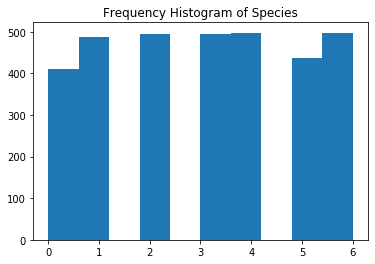

<Figure size 864x864 with 0 Axes>

In [20]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

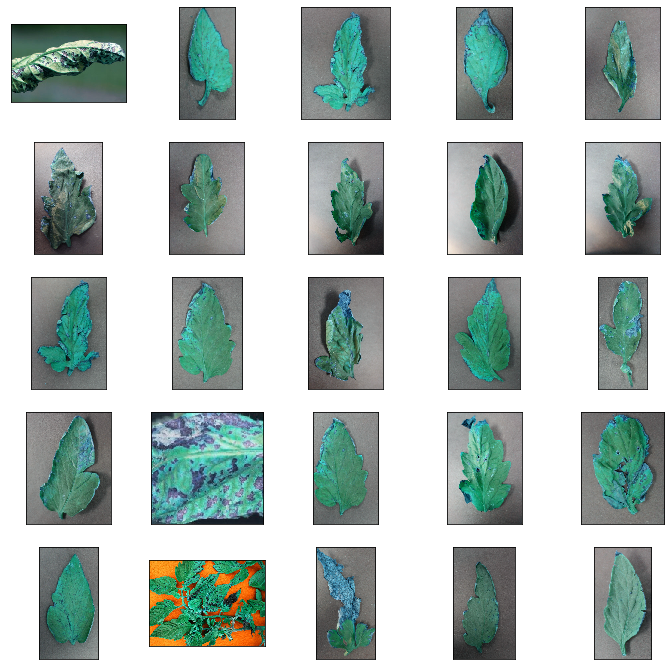

In [21]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Bacterial_spot', 5, 5)

In [22]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [23]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

3322it [00:31, 104.99it/s]


Train Shape: (3322, 224, 224, 3)


In [24]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=7)

In [25]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

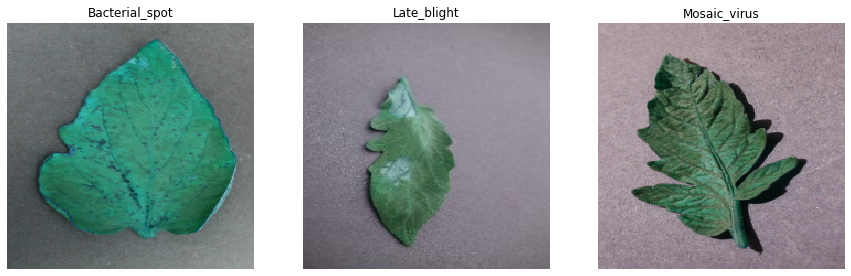

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [27]:
EPOCHS = 50
SIZE = 224
IMAGE_SIZE = [224, 224]
N_ch = 3
folders = glob('D:/Tomato PDD/ICT4SD4/data2/*')
folders

['D:/Tomato PDD/ICT4SD4/data2\\Bacterial_spot',
 'D:/Tomato PDD/ICT4SD4/data2\\Black_mold',
 'D:/Tomato PDD/ICT4SD4/data2\\Early_blight',
 'D:/Tomato PDD/ICT4SD4/data2\\Healthy',
 'D:/Tomato PDD/ICT4SD4/data2\\Late_blight',
 'D:/Tomato PDD/ICT4SD4/data2\\Mosaic_virus',
 'D:/Tomato PDD/ICT4SD4/data2\\Septoria_spot']

In [28]:
vgg16 = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

model.summary()

9412608/9406464 [==============================] - ETA:  - ETA:  - ETA: 13 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

block_3_depthwise (DepthwiseCon (None, 28, 28, 144)  1296        block_3_pad[0][0]                
__________________________________________________________________________________________________
block_3_depthwise_BN (BatchNorm (None, 28, 28, 144)  576         block_3_depthwise[0][0]          
__________________________________________________________________________________________________
block_3_depthwise_relu (ReLU)   (None, 28, 28, 144)  0           block_3_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_3_project (Conv2D)        (None, 28, 28, 32)   4608        block_3_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_3_project_BN (BatchNormal (None, 28, 28, 32)   128         block_3_project[0][0]            
__________________________________________________________________________________________________
block_4_ex

block_7_add (Add)               (None, 14, 14, 64)   0           block_6_project_BN[0][0]         
                                                                 block_7_project_BN[0][0]         
__________________________________________________________________________________________________
block_8_expand (Conv2D)         (None, 14, 14, 384)  24576       block_7_add[0][0]                
__________________________________________________________________________________________________
block_8_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_8_expand[0][0]             
__________________________________________________________________________________________________
block_8_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_8_expand_BN[0][0]          
__________________________________________________________________________________________________
block_8_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_8_expand_relu[0][0]        
__________

block_12_depthwise (DepthwiseCo (None, 14, 14, 576)  5184        block_12_expand_relu[0][0]       
__________________________________________________________________________________________________
block_12_depthwise_BN (BatchNor (None, 14, 14, 576)  2304        block_12_depthwise[0][0]         
__________________________________________________________________________________________________
block_12_depthwise_relu (ReLU)  (None, 14, 14, 576)  0           block_12_depthwise_BN[0][0]      
__________________________________________________________________________________________________
block_12_project (Conv2D)       (None, 14, 14, 96)   55296       block_12_depthwise_relu[0][0]    
__________________________________________________________________________________________________
block_12_project_BN (BatchNorma (None, 14, 14, 96)   384         block_12_project[0][0]           
__________________________________________________________________________________________________
block_12_a

__________________________________________________________________________________________________
block_16_project_BN (BatchNorma (None, 7, 7, 320)    1280        block_16_project[0][0]           
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 7, 7, 1280)   409600      block_16_project_BN[0][0]        
__________________________________________________________________________________________________
Conv_1_bn (BatchNormalization)  (None, 7, 7, 1280)   5120        Conv_1[0][0]                     
__________________________________________________________________________________________________
out_relu (ReLU)                 (None, 7, 7, 1280)   0           Conv_1_bn[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 62720)        0           out_relu[0][0]                   
__________

In [29]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/50
 - 209s - loss: 6.0897 - accuracy: 0.5064 - val_loss: 4.8064 - val_accuracy: 0.4917

Epoch 00001: val_loss improved from inf to 4.80635, saving model to model.h5
Epoch 2/50
 - 203s - loss: 2.3828 - accuracy: 0.6980 - val_loss: 6.5913 - val_accuracy: 0.4301

Epoch 00002: val_loss did not improve from 4.80635
Epoch 3/50
 - 209s - loss: 2.6101 - accuracy: 0.6830 - val_loss: 6.3844 - val_accuracy: 0.4932

Epoch 00003: val_loss did not improve from 4.80635
Epoch 4/50
 - 205s - loss: 2.4510 - accuracy: 0.7077 - val_loss: 3.9406 - val_accuracy: 0.6015

Epoch 00004: val_loss improved from 4.80635 to 3.94056, saving model to model.h5
Epoch 5/50
 - 202s - loss: 2.3744 - accuracy: 0.7320 - val_loss: 6.8061 - val_accuracy: 0.5459

Epoch 00005: val_loss did not improve from 3.94056
Epoch 6/50
 - 210s - loss: 2.3149 - accuracy: 0.7462 - val_loss: 5.4099 - val_accuracy: 0.5699

Epoch 00006: val_loss did not improve from 3.94056
Epoch 7/50
 - 214s - loss: 2.5501 - accuracy: 0.7347 - val_los

In [16]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

665/665 [==============================] - ETA: 41 - ETA: 38 - ETA: 36 - ETA: 34 - ETA: 32 - ETA: 30 - ETA: 28 - ETA: 26 - ETA: 24 - ETA: 22 - ETA: 20 - ETA: 18 - ETA: 16 - ETA: 14 - ETA: 12 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - 46s 69ms/step
Final Loss: 0.7821038066892696, Final Accuracy: 0.7443609237670898


Text(0.5, 144.41374999999996, 'Predicted')

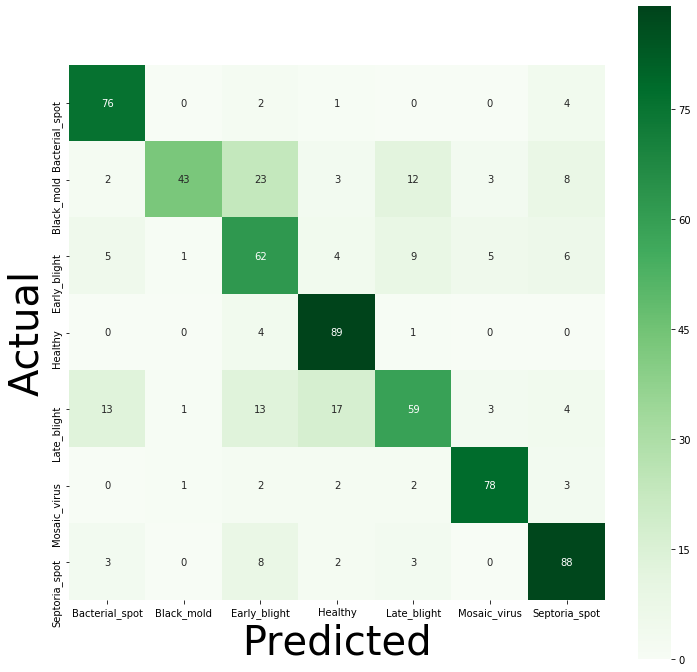

In [17]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

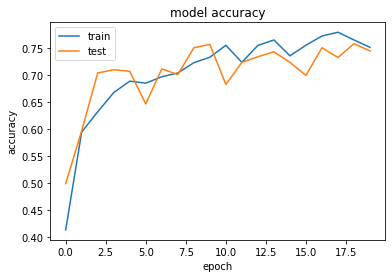

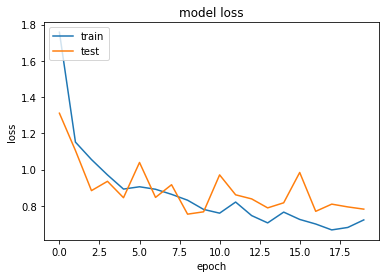

In [18]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('C:/Users/Kartik/Downloads/hqdefault.jpg', grayscale=False, target_size=(224, 224))
show_img=image.load_img('C:/Users/Kartik/Downloads/hqdefault.jpg', grayscale=False, target_size=(200, 200))
disease_class = ['Bacterial_spot','Black_mold','Early_blight','Healthy','Late_blight','Mosaic_virus','Septoria_spot']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

NameError: name 'model' is not defined